## Intro
In this notebook, we run NeuralProphet, XGBoost and RNN (LSTM) models.

Note that high hit rate can be a result of imbalance of signs in the original dataset - a better metric would be hit rate after accounting for this.

In [ ]:
## Import libraries

# Analysis
import numpy as np
import pandas as pd
!pip install neuralprophet
from neuralprophet import NeuralProphet, set_random_seed
import torch
import torch.nn as nn

# Plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.dates import DateFormatter

# Backtesting
!pip install backtrader
import backtrader as bt
import backtrader.plot

# Utilities
import pickle
import time

# Data: https://www.kaggle.com/tencars/392-crypto-currency-pairs-at-minute-resolution

# RNN method: https://medium.com/swlh/stock-price-prediction-with-pytorch-37f52ae84632
# Also see this: https://www.kaggle.com/taronzakaryan/predicting-stock-price-using-lstm-model-pytorch?scriptVersionId=59632795

In [4]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/Shared drives/MS&E 448 Power Group')

Mounted at /content/drive


## Load data and analyze stationarity

Data is hourly and is from Jan 2020 to Mar 2021. Train/val/test split is in an 80/10/10 ratio.

In [261]:
data_path = "./Datasets/bitfinex_cleaned/hour/btcusd_hourly.csv"
df = pd.read_csv(data_path)
df = df[df.time < '2021-04-01']
df_clipped = df.copy()
df = df[df.time >= '2020-01-01']

<Figure size 432x288 with 0 Axes>

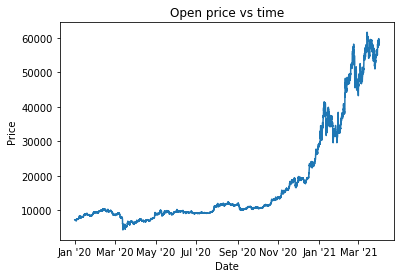

In [262]:
df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d %H:%M:%S')
plt.clf()
fig, ax = plt.subplots()
plt.plot('time', 'open', data=df)
ax.xaxis.set_major_formatter(DateFormatter('%b \'%y'))
plt.xticks(rotation=0)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Open price vs time')
plt.show()

In [263]:
ts = np.log(df_clipped['open']).diff()[1:].copy().to_frame()[-len(df):]
ts['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d %H:%M:%S')
ts_returns = ts.copy()

<Figure size 432x288 with 0 Axes>

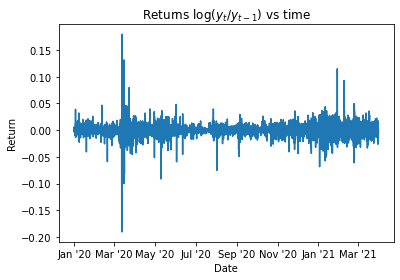

In [264]:
plt.clf()
fig, ax = plt.subplots()
plt.plot('time', 'open', data=ts)
ax.xaxis.set_major_formatter(DateFormatter('%b \'%y'))
plt.xticks(rotation=0)
plt.xlabel('Date')
plt.ylabel('Return')
plt.title('Returns log($y_t$/$y_{t-1}$) vs time')
plt.show()

In [265]:
df = df_clipped.copy()

regime_size = 240 # I.e., 10 days
sum_over = 1

df = df.iloc[df[df.time == '2020-01-01 00:00:00'].index[0]-regime_size-(1+sum_over):]
ts = np.log(df['open']).diff()[1:].copy()
ts = ((ts - ts.rolling(window=regime_size).mean().shift(1+sum_over))/ts.rolling(window=regime_size).std().shift(1+sum_over))[regime_size-1+(1+sum_over):]

<Figure size 432x288 with 0 Axes>

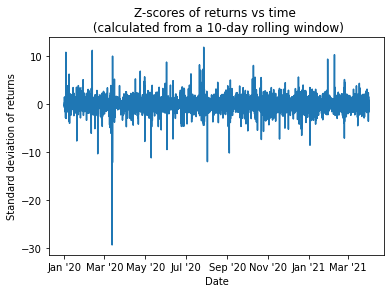

In [266]:
ts = ts.to_frame()
ts['time'] = pd.to_datetime(df.time[regime_size+1+sum_over:], format='%Y-%m-%d %H:%M:%S')
plt.clf()
fig, ax = plt.subplots()
plt.plot('time', 'open', data=ts)
ax.xaxis.set_major_formatter(DateFormatter('%b \'%y'))
plt.xticks(rotation=0)
plt.xlabel('Date')
plt.ylabel('Standard deviation of returns')
plt.title('Z-scores of returns vs time \n (calculated from a 10-day rolling window)')
plt.show()

## Prepare data

In [286]:
def split_data(ts, window, sum_over):
    data_raw = ts
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - window): 
        data.append(data_raw[index: index + window]) # * np.array([1/(19-t) for t in range(19)] + [1,1]))
    
    data = np.array(data);
    val_and_test_set_size = int(np.round(0.2*data.shape[0]));
    val_set_size = int(val_and_test_set_size/2);
    # test_set_size = df.iloc[-1:].index[0] - df[df.time == '2020-06-10 19:13:00'].index[0] + 1;
    train_set_size = data.shape[0] - (val_and_test_set_size);
    
    x_train = data[:train_set_size,:-(1+sum_over)]
    y_train = np.sum(data[:train_set_size,-sum_over:], axis=1)

    x_val = data[train_set_size:train_set_size+val_set_size,:-(1+sum_over)]
    y_val = np.sum(data[train_set_size:train_set_size+val_set_size,-sum_over:], axis=1)

    x_test = data[train_set_size+val_set_size:,:-(1+sum_over)]
    y_test = np.sum(data[train_set_size+val_set_size:,-sum_over:], axis=1)
    
    return [x_train, y_train, x_val, y_val, x_test, y_test]

sum_over = 1
window = 30+1+sum_over # choose sequence length
x_train, y_train, x_val, y_val, x_test, y_test = split_data(ts['open'], window, sum_over)

In [287]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((8730, 30), (8730,), (1091, 30), (1091,), (1091, 30), (1091,))

In [329]:
def get_pred_features(y, preds):

  # Get predictions and actuals
  features = pd.DataFrame([[int(x) for x in range(1,len(y)+1)],y,preds]).transpose()
  features.columns = ['time','y','yhat']
  features['yhat_decile'] = pd.DataFrame(pd.qcut(features['yhat'],q=10,labels=False,duplicates='drop'))
  features['hit'] = 1*(np.sign(features['y']) == np.sign(features['yhat']))

  # Summarize by decile
  summary = features.drop('time', axis=1).groupby('yhat_decile').mean('hit')
  summary['corr'] = features.groupby('yhat_decile').corr().xs('y', level=1, drop_level=True)['yhat']
  summary.columns = ['y_mean','yhat_mean','hit_rate','correlation']
  summary = summary.fillna(0).reset_index()
  features = features.merge(summary, how='left', on='yhat_decile')

  return features, summary

In [289]:
def print_plots(y, preds, features, summary):

  plt.clf()
  fig, axes = plt.subplots(1, 3, figsize=(20, 4))

  # Plot prediction and actuals vs time
  axes[0].plot(y)
  axes[0].plot(preds)
  axes[0].set_title("Prediction vs time")
  axes[0].set_xlabel("Time")
  axes[0].set_ylabel("Prediction")

  # Plot scatterplot
  axes[1].scatter(features['y'], features['yhat'], s=1)
  axes[1].set_title('Scatterplot of predicted (yhat) vs actual (y)')
  axes[1].set_xlabel('Actual (y)')
  axes[1].set_ylabel('Predicted (yhat)')

  # Plot statistics
  axes[2].plot(summary.yhat_decile, summary.hit_rate, label='hit rate')
  axes[2].plot(summary.yhat_decile, summary.correlation, label='correlation')
  axes[2].legend()
  axes[2].set_xticks(range(len(summary)))
  axes[2].hlines(0,0,9)
  axes[2].set_title('Statistics vs decile')
  axes[2].set_xlabel('Decile')
  axes[2].set_ylabel('Value')

  fig.show()

## Create backtrader functions

In [290]:
df_raw = df_clipped.copy()
df_raw = df_raw[df_raw.time >= '2020-01-01']
df_raw['datetime'] = pd.to_datetime(df_raw['time'])

# model_name can be: neuralprophet, xgboost, rnn
def load_predictions(preds_test, preds_val_summary, actuals = df_raw, threshold = 0.1):

  preds = preds_test.copy()
  preds_val_summary = preds_val_summary.copy()
  actuals = actuals.copy()

  # Shift decile so that we trade on the previous time point as expected (and later close on the next time point)
  #preds['yhat_decile'] =  [int(x) for x in preds['yhat_decile'].shift(-2).fillna(-1)]
  preds['yhat_decile'] = pd.DataFrame(pd.qcut(preds['yhat'],q=10,labels=False)).shift(-2).fillna(-1).astype(int)
  preds['hit'] = 1*(np.sign(preds['y']) == np.sign(preds['yhat']))
  preds = preds.drop(['correlation','yhat_mean'], axis=1)
  preds = preds.merge(preds_val_summary[['yhat_decile','correlation','yhat_mean']], how='left', on='yhat_decile')
  preds['amount'] = (np.abs(preds['correlation']) >= threshold) * np.sign(preds['correlation']) * np.sign(preds['yhat_mean']) * 0.1

  # Concatenate to actuals and return
  return pd.concat([actuals[-len(preds):].reset_index(),preds],axis=1).fillna(0)

In [291]:
# Define datafeed class
class PandasBitfinex(bt.feeds.PandasData):
    lines = ('yhat','yhat_decile','correlation','amount',)
    params = (
      ('datetime', -1),
      ('open', -1),
      ('high', -1),
      ('low', -1),
      ('close', -1),
      ('volume', -1),
      ('openinterest', None),
      ('yhat', -1),
      ('yhat_decile', -1),
      ('correlation', -1),
      ('amount', -1),
    )

In [408]:
# define transaction costs and trading parameters
class BitmexCommissionInfo(bt.CommissionInfo):
  params = (
      ("commission", 0),
      ("margin", None),
      ("stocklike", False),
      ("interest", 0.0),
      ("leverage", 1.0),
  )

In [338]:
class FixedStrategy(bt.Strategy):
  def __init__(self):
    self.stop_trading = False
    self.just_traded = ''
    self.order = None
    self.amount = 0
    self.dataclose = self.datas[0].close

  def notify_order(self, order):
    if order.status in [order.Submitted, order.Accepted]:
      #order submitted or accepted by broker
      return
    # if order.status in [order.Completed]: #check if order has been completed, could be rejected if not enough cash
    #   if order.isbuy():
    #     print("Time %03d Buy order executed at %f" % (len(self), order.executed.price))
    #   elif order.issell():
    #     print("Time %03d Sell order executed at %f" % (len(self), order.executed.price))
    #   self.bar_executed = len(self)
    elif order.status in [order.Canceled, order.Margin, order.Rejected]:
      print("Order was not placed")
    total_position = self.position.size * self.position.price
    # print("Total Position:", total_position)
    
    # if self.position.size == 0:
    #   print(cerebro.broker.getvalue())

    self.order = None

  def next(self):
    #print('Timesteps so far: %03d Open: %f Close: %f Volume: %f Position %f' \
    #      % (len(self), self.data.l.open[0], self.data.l.close[0], self.data.l.volume[0], self.position.size))

    self.amount = 0
    if self.just_traded == 'short':
      self.amount += 0.1
      self.just_traded = ''

    if self.just_traded == 'long':
      self.amount += -0.1
      self.just_traded = ''

    if self.data.amount.get()[0] < 0:
      self.amount += self.data.amount.get()[0]
      self.just_traded = 'short'
    
    if self.data.amount.get()[0] > 0:
      self.amount += self.data.amount.get()[0]
      self.just_traded = 'long'

    # if self.data.yhat_decile.get()[0] in [1]: # self.data.amount.get()[0] < 0:
    #   self.amount += -0.1
    #   self.just_traded = 'short'
    
    # if self.data.yhat_decile.get()[0] in [3,4,6]: # self.data.amount.get()[0] > 0:
    #   self.amount += 0.1
    #   self.just_traded = 'long'

    if self.amount > 0:
      self.order = self.buy(size = self.amount)
    elif self.amount < 0:
      self.order = self.sell(size = self.amount)

In [415]:
def run_backtrader(data, sharpe_only = False):
  cerebro = bt.Cerebro()
  cerebro.addstrategy(FixedStrategy)
  data_feed = PandasBitfinex(dataname = data)
  cerebro.adddata(data_feed)
  cerebro.broker.addcommissioninfo(BitmexCommissionInfo())
  cerebro.broker.setcash(1000000.0)
  
  if not sharpe_only:
    print("START VALUE", cerebro.broker.getvalue())

  cerebro.addanalyzer(bt.analyzers.SharpeRatio, timeframe=bt.TimeFrame.Minutes, compression=60, riskfreerate=0, factor = 365*24, annualize = True)
  results = cerebro.run()
  sharpe_ratio = results[0].analyzers.sharperatio.get_analysis()['sharperatio']

  if not sharpe_only:
    print('Sharpe Ratio: ', sharpe_ratio)
    print("END VALUE", cerebro.broker.getvalue())
    cerebro.plot(iplot = False)
    plt.show()
  
  if sharpe_only:
    return sharpe_ratio

In [482]:
# Plot Sharpe ratios for both the validation and test set vs the correlation threshold to trade at
def plot_sharpe_ratios(val_features, val_summary, test_features, limit = 0.3):

  # Compute all Sharpe ratio values
  limit = 0.3
  range = np.linspace(0,limit - 0.01,int(limit * 100))
  sharpe_val = [run_backtrader(load_predictions(val_features, val_summary, df_raw, x), sharpe_only=True) for x in range]
  sharpe_test = [run_backtrader(load_predictions(test_features, val_summary, df_raw, x), sharpe_only=True) for x in range]

  # Plot Sharpe ratios
  plt.clf()
  plt.plot(range, sharpe_val, label='Validation set')
  plt.plot(range, sharpe_test, label='Test set')
  plt.hlines(0,0,limit - 0.01)
  plt.xlabel('Threshold')
  plt.ylabel('Sharpe ratio')
  plt.title('Sharpe ratios vs correlation threshold to trade at')
  plt.legend()
  plt.show()

  # Get optimum hyperparamter-tuned value
  best_threshold = np.argmax([x if x is not None else -np.inf for x in sharpe_val])
  print('Best threshold for val: '+str(best_threshold/100))
  print('Corresponding Sharpe ratio for test: '+str(sharpe_test[best_threshold]))

  return sharpe_val, sharpe_test, best_threshold/100, sharpe_test[best_threshold]

## Run models

### NeuralProphet

In [392]:
df_all = ts[['time','open']].copy().rename({'time':'ds','open':'y'},axis=1)
df_train1 = df_all.iloc[:len(y_train)].reset_index(drop=True)
df_val = df_all.iloc[len(y_train):len(y_train)+len(y_val)].reset_index(drop=True)
df_train2 = df_all.iloc[:len(y_train)+len(y_val)].reset_index(drop=True)
df_test = df_all.iloc[len(y_train)+len(y_val):].reset_index(drop=True)

In [393]:
m = NeuralProphet()
set_random_seed(0)
train1_metrics = m.fit(df_train1, validate_each_epoch=True, freq='h')
val_metrics = m.test(df_val)
preds_val = m.predict(m.make_future_dataframe(df_train1, periods=len(df_val)))

m = NeuralProphet()
set_random_seed(0)
train2_metrics = m.fit(df_train2, validate_each_epoch=True, freq='h')
test_metrics = m.test(df_test)
preds_test = m.predict(m.make_future_dataframe(df_train2, periods=len(df_test)))

INFO: nprophet.utils - set_auto_seasonalities: Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 32
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 9


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E-01
Epoch[9/9]: 100%|██████████| 9/9 [00:04<00:00,  2.22it/s, SmoothL1Loss=0.000463, MAE=0.691, RegLoss=0, MAE_val=0.768, SmoothL1Loss_val=0.000425]
INFO: nprophet - _evaluate: Validation metrics:    SmoothL1Loss    MAE
1         0.000  0.764
INFO: nprophet.utils - set_auto_seasonalities: Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 32
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 8


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E-01
Epoch[8/8]: 100%|██████████| 8/8 [00:03<00:00,  2.01it/s, SmoothL1Loss=0.000464, MAE=0.703, RegLoss=0, MAE_val=0.75, SmoothL1Loss_val=0.000411]
INFO: nprophet - _evaluate: Validation metrics:    SmoothL1Loss    MAE
1         0.000  0.710


<Figure size 432x288 with 0 Axes>

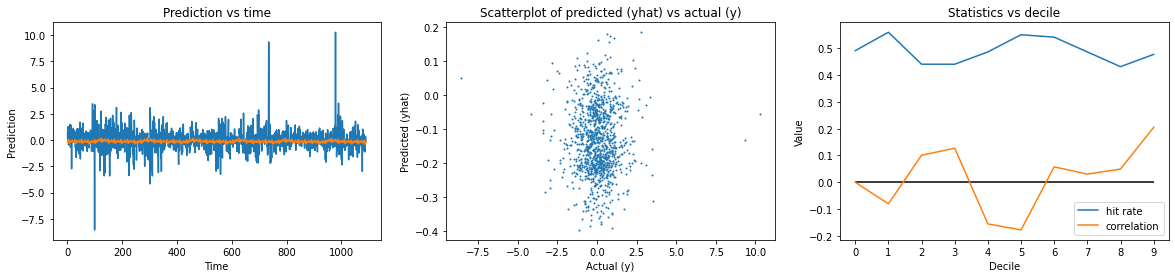

In [394]:
df_val_features_np, df_val_summary_np = get_pred_features(df_val['y'], preds_val['yhat1'])
print_plots(df_val['y'], preds_val['yhat1'], df_val_features_np, df_val_summary_np)
df_test_features_np, df_test_summary_np = get_pred_features(df_test['y'], preds_test['yhat1'])

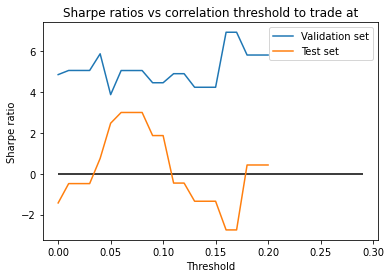

Best threshold for val: 0.16
Corresponding Sharpe ratio for test: -2.749307237762526


In [483]:
sharpe_val_np, sharpe_test_np, best_val_threshold_np, sharpe_np = plot_sharpe_ratios(df_val_features_np, df_val_summary_np, df_test_features_np, limit = 0.3)

START VALUE 1000000.0
Sharpe Ratio:  -2.749307237762526
END VALUE 999243.6049717251


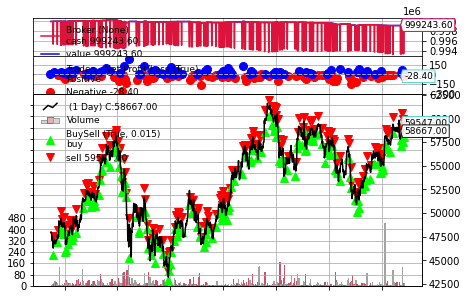

In [475]:
run_backtrader(load_predictions(df_test_features_np, df_val_summary_np, df_raw, 0.16))

### XGBoost

In [300]:
import xgboost as xgb

d_train = xgb.DMatrix(x_train, y_train)
d_val = xgb.DMatrix(x_val, y_val)

params = {'max_depth': 6}
num_rounds = 15
bst = xgb.train(params, d_train, num_rounds)

<Figure size 432x288 with 0 Axes>

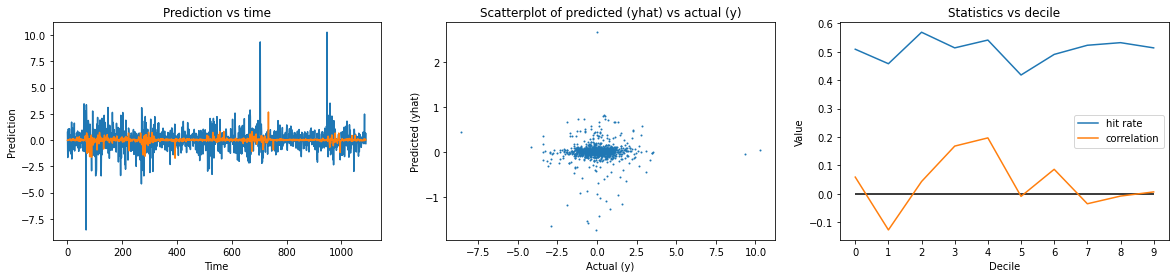

In [342]:
df_val_features_xgb, df_val_summary_xgb = get_pred_features(y_val, bst.predict(xgb.DMatrix(x_val, y_val)))
print_plots(y_val, bst.predict(xgb.DMatrix(x_val, y_val)), df_val_features_xgb, df_val_summary_xgb)
df_test_features_xgb, df_test_summary_xgb = get_pred_features(y_test, bst.predict(xgb.DMatrix(x_test, y_test)))

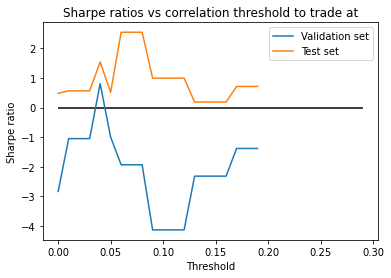

Best threshold for val: 0.04
Corresponding Sharpe ratio for test: 1.5391223248408228


In [484]:
sharpe_val_xgb, sharpe_test_xgb, best_val_threshold_xgb, sharpe_xgb = plot_sharpe_ratios(df_val_features_xgb, df_val_summary_xgb, df_test_features_xgb, limit = 0.3)

START VALUE 1000000.0
Sharpe Ratio:  1.5391223248408228
END VALUE 1000654.1096909881


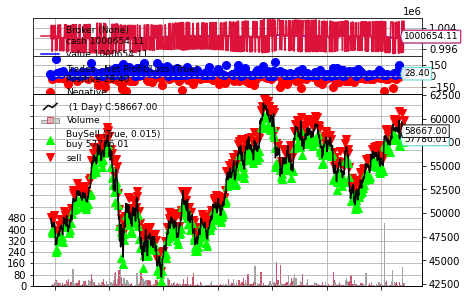

In [457]:
run_backtrader(load_predictions(df_test_features_xgb, df_val_summary_xgb, df_raw, 0.04))

### LSTM

In [358]:
def make_tensor(*vars):
  return [torch.from_numpy(var.reshape(*var.shape, 1)).type(torch.Tensor) for var in vars]
x_train, y_train, x_val, y_val, x_test, y_test = make_tensor(*[x_train, y_train, x_val, y_val, x_test, y_test])

In [359]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [380]:
input_dim = 1
hidden_dim = 64
num_layers = 2
output_dim = 1
num_epochs = 20

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [381]:
hist = np.zeros(num_epochs)
start_time = time.time()
for t in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  1.2584832906723022
Epoch  1 MSE:  1.3077067136764526
Epoch  2 MSE:  1.252469539642334
Epoch  3 MSE:  1.2545770406723022
Epoch  4 MSE:  1.2581794261932373
Epoch  5 MSE:  1.2574982643127441
Epoch  6 MSE:  1.2551326751708984
Epoch  7 MSE:  1.2528969049453735
Epoch  8 MSE:  1.2516117095947266
Epoch  9 MSE:  1.2516484260559082
Epoch  10 MSE:  1.2525749206542969
Epoch  11 MSE:  1.2529141902923584
Epoch  12 MSE:  1.2523748874664307
Epoch  13 MSE:  1.2516930103302002
Epoch  14 MSE:  1.251325249671936
Epoch  15 MSE:  1.251288890838623
Epoch  16 MSE:  1.2514299154281616
Epoch  17 MSE:  1.251590371131897
Epoch  18 MSE:  1.251666784286499
Epoch  19 MSE:  1.2516224384307861
Training time: 84.34911346435547


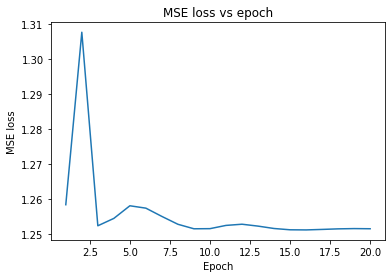

In [382]:
plt.clf()
plt.plot(range(1,len(hist)+1),hist)
plt.title("MSE loss vs epoch")
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.show()

<Figure size 432x288 with 0 Axes>

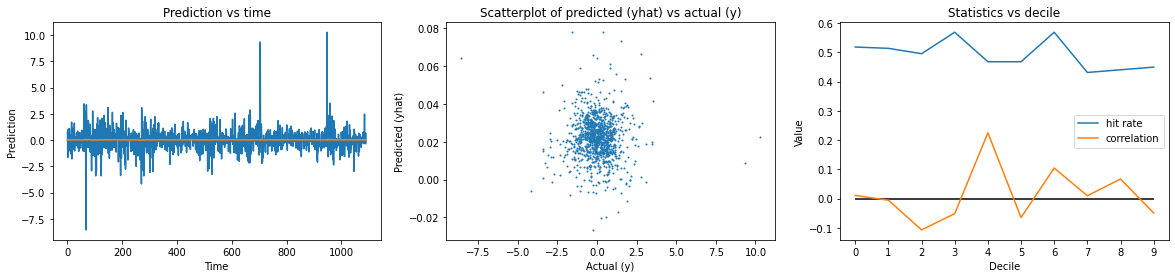

In [383]:
with torch.no_grad():
  preds_val = model(x_val).numpy().squeeze()
  preds_test = model(x_test).numpy().squeeze()

df_val_features_rnn, df_val_summary_rnn = get_pred_features(y_val.numpy().squeeze(), preds_val)
print_plots(y_val.numpy().squeeze(), preds_val, df_val_features_rnn, df_val_summary_rnn)
df_test_features_rnn, df_test_summary_rnn = get_pred_features(y_test.numpy().squeeze(), preds_test)

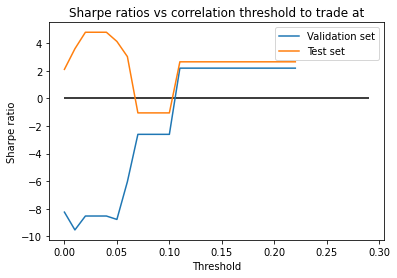

Best threshold for val: 0.11
Corresponding Sharpe ratio for test: 2.641936264353433


In [485]:
sharpe_val_rnn, sharpe_test_rnn, best_val_threshold_rnn, sharpe_rnn = plot_sharpe_ratios(df_val_features_rnn, df_val_summary_rnn, df_test_features_rnn, limit = 0.3)

START VALUE 1000000.0
Sharpe Ratio:  2.641936264353433
END VALUE 1000382.8787406355


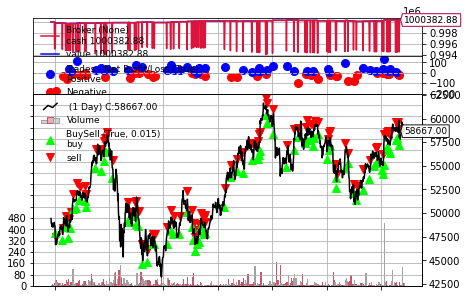

In [478]:
run_backtrader(load_predictions(df_test_features_rnn, df_val_summary_rnn, df_raw, 0.11))